# Notes - DS births recorded

In [1]:
import duckdb
import os
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from chance import get_ds_lb_nt_probability_array
from graphviz import Digraph
from sympy.physics.units import magnetic_density

from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [2]:
con = duckdb.connect("./data/us_births.db", read_only=True)

## Total records

There are 143 million records, including 68,515 live births with Down syndrome recorded. The status of Down syndrome is unknown in 23.6 million records (16.5%).

In [3]:
totals_df = con.execute(
    """
    SELECT DISTINCT
        down_ind,
        COUNT(*) as count_lb
    FROM
        us_births
    GROUP BY
        down_ind
    ORDER BY
        down_ind
    """
).df()
print(f"Total live births: {totals_df['count_lb'].sum()}")
totals_df

Total live births: 142865348


,down_ind,count_lb
0,0,119226426
1,1,68515
2,<NA>,23570407


## What does the flag `f_ca_downs` indicate?

2023 User Guide states "Reporting Flag for Down Syndrome: 0 = Non-Reporting, 1 = Reporting". However, the ratio of DS births recorded is higher in the 'Non-Reporting' group than in the ''Reporting' group. For group where `f_ca_downs` is not known (pre-2004), the ratio is similar to the 'Reporting' group.

We therefore disregard this flag in our analysis.

In [4]:
flag_df = con.execute(
    """
    SELECT DISTINCT
        f_ca_downs,
        COUNT(*) as count_lb,
        SUM(down_ind) as count_ds_rec,
        SUM(down_ind)  / COUNT(*) as ratio_ds_rec
    FROM
        us_births
    WHERE down_ind IS NOT NULL
    GROUP BY
        f_ca_downs
    ORDER BY
        f_ca_downs
    """
).df()
flag_df

,f_ca_downs,count_lb,count_ds_rec,ratio_ds_rec
0,0,809367,5977.0,0.007385
1,1,65174124,33760.0,0.000518
2,<NA>,53311450,28778.0,0.000540


In [5]:
flag_year_df = con.execute(
    """
    SELECT DISTINCT
        year,
        f_ca_downs,
        COUNT(*) as count_lb,
        SUM(down_ind) as count_ds_rec,
        SUM(down_ind)  / COUNT(*) as ratio_ds_rec
    FROM
        us_births
    WHERE down_ind IS NOT NULL
    GROUP BY
        year, f_ca_downs
    ORDER BY
        year, f_ca_downs
    """
).df()
flag_year_df

,year,f_ca_downs,count_lb,count_ds_rec,ratio_ds_rec
0,1989,<NA>,3335026,1954.0,0.000586
1,1990,<NA>,3642012,1983.0,0.000544
2,1991,<NA>,3617461,1791.0,0.000495
3,1992,<NA>,3625332,1816.0,0.000501
4,1993,<NA>,3743354,1763.0,0.000471
5,1994,<NA>,3744302,1706.0,0.000456
6,1995,<NA>,3625036,1640.0,0.000452
7,1996,<NA>,3812275,1677.0,0.000440
8,1997,<NA>,3799264,1663.0,0.000438
9,1998,<NA>,3851486,1682.0,0.000437


### Unknowns

Many unknowns are seen in 2003 and for some years thereafter.

We treat 'Unknown' as 'Not recorded' in our analyses.

In [10]:
ds_rec_yr_ex_df = con.execute(
    """
    SELECT
        year,
        SUM(CASE WHEN down_ind IS NULL THEN 1 ELSE 0 END) AS count_NA,
        SUM(CASE WHEN down_ind = 0 THEN 1 ELSE 0 END) AS count_0,
        SUM(CASE WHEN down_ind = 1 THEN 1 ELSE 0 END) AS count_1
    FROM us_births
    GROUP BY year
    ORDER BY year;
    """
).df()
ds_rec_yr_ex_df

,year,count_NA,count_0,count_1
0,1989,710667.0,3333072.0,1954.0
1,1990,520905.0,3640029.0,1983.0
2,1991,497881.0,3615670.0,1791.0
3,1992,444096.0,3623516.0,1816.0
4,1993,261169.0,3741591.0,1763.0
5,1994,212623.0,3742596.0,1706.0
6,1995,277976.0,3623396.0,1640.0
7,1996,82599.0,3810598.0,1677.0
8,1997,85065.0,3797601.0,1663.0
9,1998,93706.0,3849804.0,1682.0


## Counts by year

In [14]:
ds_rec_yr_df = con.execute(
    """
    SELECT DISTINCT
        year,
        COUNT(*) as count_lb,
        SUM(down_ind) as count_down_ind,
        SUM(p_ds_lb_nt) as count_ds_lb_nt,
        SUM(p_ds_lb_wt_mage) as count_ds_lb_wt_mage,
        SUM(down_ind)  / COUNT(*) as prob_ds_rec,
        SUM(down_ind) / SUM(p_ds_lb_nt) as ratio_nt_recorded,
        SUM(down_ind) / SUM(p_ds_lb_wt_mage) as ratio_wt_mage_recorded,
    FROM
        us_births
    GROUP BY
        year
    ORDER BY
        year
    """
).df()
ds_rec_yr_df

,year,count_lb,count_down_ind,count_ds_lb_nt,count_ds_lb_wt_mage,prob_ds_rec,ratio_nt_recorded,ratio_wt_mage_recorded
0,1989,4045693,1954.0,5435.804076,4199.990792,0.000483,0.359468,0.465239
1,1990,4162917,1983.0,5716.629219,4391.978707,0.000476,0.346883,0.451505
2,1991,4115342,1791.0,5794.837984,4431.747206,0.000435,0.309068,0.404130
3,1992,4069428,1816.0,5888.002906,4406.742137,0.000446,0.308424,0.412096
4,1993,4004523,1763.0,5957.920280,4376.743186,0.000440,0.295909,0.402811
5,1994,3956925,1706.0,6063.337957,4360.634964,0.000431,0.281363,0.391227
6,1995,3903012,1640.0,6140.807701,4374.942505,0.000420,0.267066,0.374862
7,1996,3894874,1677.0,6279.330012,4280.770270,0.000431,0.267067,0.391752
8,1997,3884329,1663.0,6396.586350,4365.918492,0.000428,0.259982,0.380905
9,1998,3945192,1682.0,6598.625178,4482.158335,0.000426,0.254902,0.375266


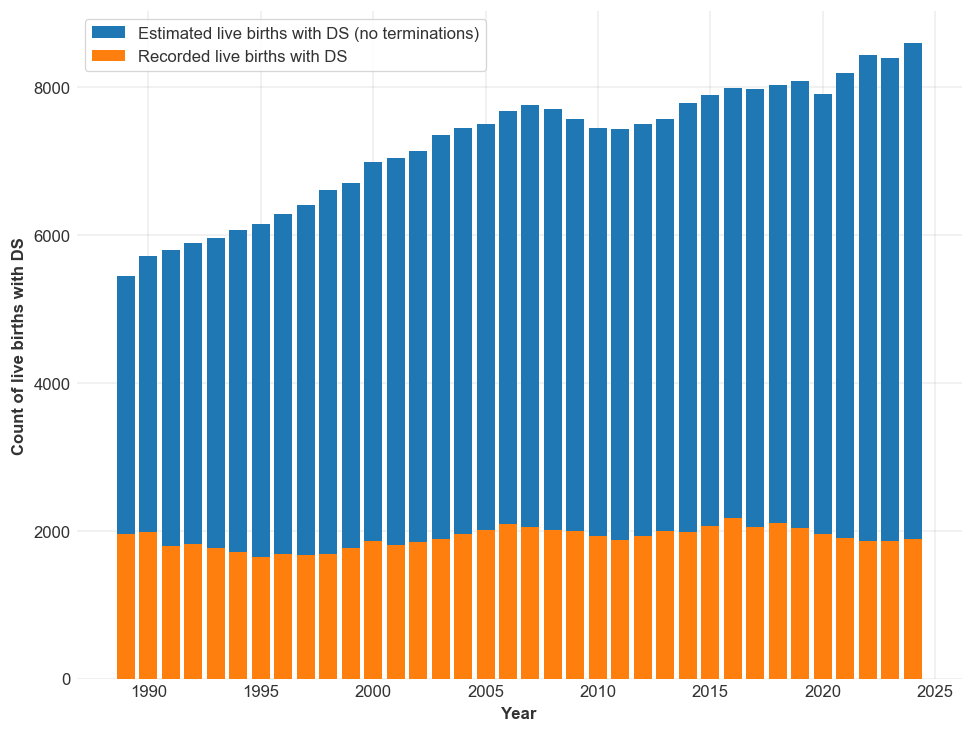

In [7]:
plt.bar(ds_rec_yr_df["year"], ds_rec_yr_df["count_ds_nt"], label="Estimated live births with DS (no terminations)")
plt.bar(ds_rec_yr_df["year"], ds_rec_yr_df["count_ds_rec"], label="Recorded live births with DS")
plt.xlabel("Year")
plt.ylabel("Count of live births with DS")
plt.legend()


Text(0.5, 1.0, 'Ratio of live births with DS recorded to estimated (no terminations)')

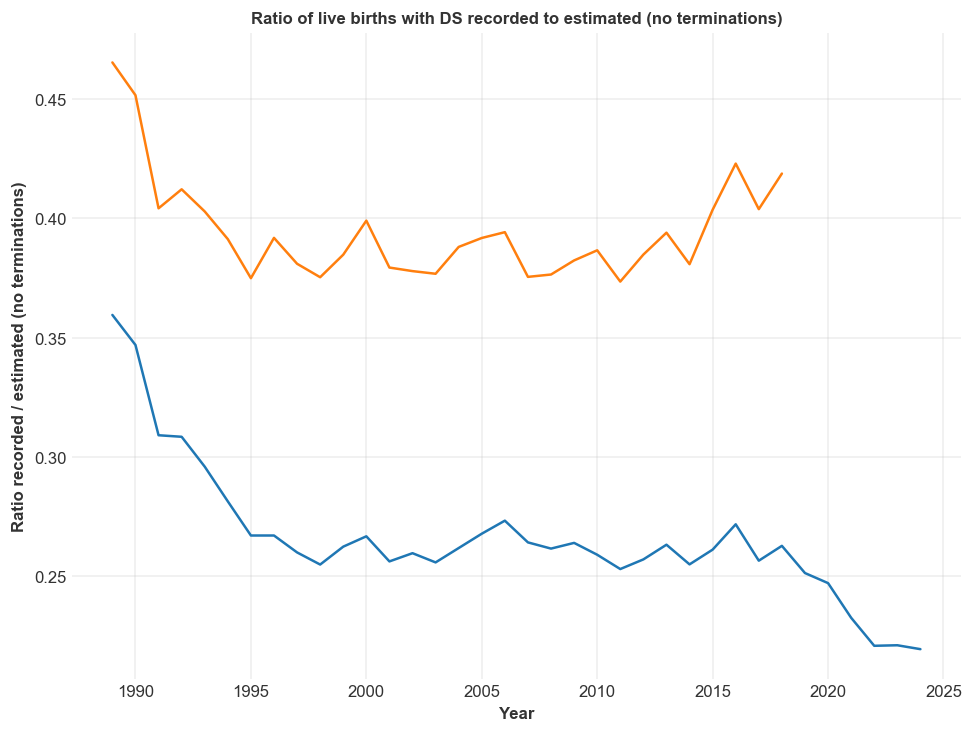

In [16]:
plt.plot(ds_rec_yr_df["year"], ds_rec_yr_df["ratio_nt_recorded"])
plt.plot(ds_rec_yr_df["year"], ds_rec_yr_df["ratio_wt_mage_recorded"])
plt.xlabel("Year")
plt.ylabel("Ratio recorded / estimated (no terminations)")
plt.title("Ratio of live births with DS recorded to estimated (no terminations)")

In [17]:
con.close()